**Install requirements**

In [ ]:
#!pip3 install 'torch==1.3.1'
#!pip3 install 'torchvision==0.5.0'
#!pip3 install 'Pillow-SIMD'
#!pip3 install 'tqdm'

**Import libraries**

In [1]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

**Set arguments**


In [2]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7 

ALPHA = 0.5

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.001          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 5

**Define Data Preprocessing**

In [3]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [4]:
# Clone github repository with data
if not os.path.isdir('./pacs'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS
  !mv 'Homework3-PACS' 'pacs'

DATA_DIR = 'pacs/PACS'

# Prepare Pytorch train/test Datasets
p_set=torchvision.datasets.ImageFolder(DATA_DIR+'/photo', transform = train_transform)
a_set=torchvision.datasets.ImageFolder(DATA_DIR+'/art_painting', transform = eval_transform)
c_set=torchvision.datasets.ImageFolder(DATA_DIR+'/cartoon')
s_set=torchvision.datasets.ImageFolder(DATA_DIR+'/sketch')

**Prepare Dataloaders**

In [5]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(p_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

test_dataloader = DataLoader(a_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [7]:
!rm -r aiml2020

In [6]:
if not os.path.isdir('./aiml2020'):
  !git clone https://github.com/GianlucaMega/aiml2020.git

from aiml2020.alexnet_modified2 import alexnet2

net = alexnet2() # Loading AlexNet model

net.dann_classifier.load_state_dict(net.classifier.state_dict())
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 7 outputs for PACS
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
net.dann_classifier[6] = nn.Linear(4096, 2)


# We just changed the last layer of AlexNet with a new fully connected layer with 7 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

In [8]:
net.state_dict

<bound method Module.state_dict of alexnet2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9

**Prepare Training**

In [7]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [11]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0

losses = [0 for i in range(NUM_EPOCHS)]

accuracy = [0 for i in range(NUM_EPOCHS)]

losses_src = [0 for i in range(NUM_EPOCHS)]

accuracy_src = [0 for i in range(NUM_EPOCHS)]

losses_dest = [0 for i in range(NUM_EPOCHS)]

accuracy_dest = [0 for i in range(NUM_EPOCHS)]

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  tot_epoch_losses = 0
  tot_epoch_steps = 0
  tot_epoch_losses_src = 0
  tot_epoch_losses_dest = 0
  running_corrects = 0
  srcdomcorr = 0
  destdomcorr = 0
  dataloader_iterator = iter(test_dataloader)

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    zero_labels = torch.zeros(images.size()[0],dtype=torch.long).to(DEVICE)
    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('LABEL CLASSIFIER Step {}, Loss {}'.format(current_step, loss.item()))

    tot_epoch_losses += loss.item()
    tot_epoch_steps += 1

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients


    #Point b.ii
    outputs = net(images,ALPHA)
    _, preds = torch.max(outputs.data, 1)
    srcdomcorr += torch.sum(preds == zero_labels).data.item()
    loss = criterion(outputs, zero_labels)
        # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('DOMAIN CLASSIFIER (SOURCE) Step {}, Loss {}'.format(current_step, loss.item()))

    tot_epoch_losses_src += loss.item()
    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients


    #Point b.iii
    
    try:
        images, labels = next(dataloader_iterator)
    except StopIteration:
        dataloader_iterator = iter(dataloader)
        images, labels = next(dataloader_iterator)

    images = images.to(DEVICE)
    one_labels = torch.ones(images.size()[0],dtype=torch.long).to(DEVICE)
    outputs = net(images,ALPHA)
    _, preds = torch.max(outputs.data, 1)
    srcdomcorr += torch.sum(preds == one_labels).data.item()
    loss = criterion(outputs, one_labels)
        # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('DOMAIN CLASSIFIER (DEST) Step {}, Loss {}'.format(current_step, loss.item()))

    tot_epoch_losses_dest += loss.item()
    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients


    #############################
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Calculate Accuracy label predictor
  accuracy[epoch] = running_corrects / float(tot_epoch_steps)
  losses[epoch] = tot_epoch_losses/tot_epoch_steps

    # Calculate Accuracy domain classifier (src)
  accuracy_src[epoch] = srcdomcorr / float(tot_epoch_steps)
  losses_src[epoch] = tot_epoch_losses_src/tot_epoch_steps

  # Calculate Accuracy domain classifier (dest)
  accuracy_dest[epoch] = destdomcorr / float(tot_epoch_steps)
  losses_dest[epoch] = tot_epoch_losses_dest/tot_epoch_steps


  # Step the scheduler
  scheduler.step() 



Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


LABEL CLASSIFIER Step 0, Loss 2.02512264251709
DOMAIN CLASSIFIER (SOURCE) Step 0, Loss 0.4096129536628723
DOMAIN CLASSIFIER (DEST) Step 0, Loss 1.696238398551941
LABEL CLASSIFIER Step 5, Loss 0.886570394039154
DOMAIN CLASSIFIER (SOURCE) Step 5, Loss 0.3203888237476349
DOMAIN CLASSIFIER (DEST) Step 5, Loss 0.5287711024284363
Starting epoch 2/30, LR = [0.001]
LABEL CLASSIFIER Step 10, Loss 0.4139479994773865
DOMAIN CLASSIFIER (SOURCE) Step 10, Loss 0.12686659395694733
DOMAIN CLASSIFIER (DEST) Step 10, Loss 0.5549924373626709
Starting epoch 3/30, LR = [0.001]
LABEL CLASSIFIER Step 15, Loss 0.2814818024635315
DOMAIN CLASSIFIER (SOURCE) Step 15, Loss 0.2508505582809448
DOMAIN CLASSIFIER (DEST) Step 15, Loss 0.1479603350162506
Starting epoch 4/30, LR = [0.001]
LABEL CLASSIFIER Step 20, Loss 0.2428465038537979
DOMAIN CLASSIFIER (SOURCE) Step 20, Loss 0.2686055302619934
DOMAIN CLASSIFIER (DEST) Step 20, Loss 0.1952231377363205
Starting epoch 5/30, LR = [0.001]
LABEL CLASSIFIER Step 25, Loss 0.

		LOSS


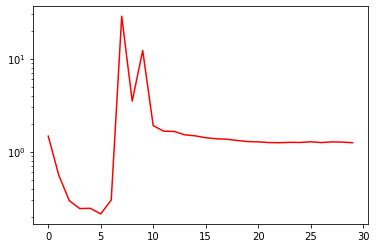

		ACCURACY


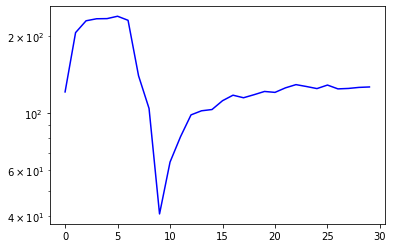

In [12]:
#TRAIN LOSS
print("\t\tLOSS")
plt.figure()
plt.plot(range(NUM_EPOCHS), losses, color='red')
plt.semilogy()
plt.show()
print("\t\tACCURACY")
plt.figure()
plt.plot(range(NUM_EPOCHS), accuracy, color='blue')
plt.semilogy()
plt.show()

		LOSS


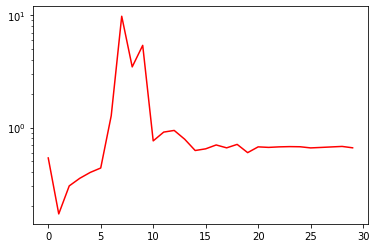

		ACCURACY


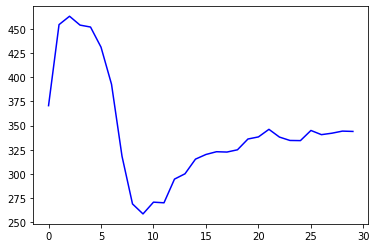

In [16]:
#DOM CLASS SRC LOSS
print("\t\tLOSS")
plt.figure()
plt.plot(range(NUM_EPOCHS), losses_src, color='red')
plt.semilogy()
plt.show()
print("\t\tACCURACY")
plt.figure()
plt.plot(range(NUM_EPOCHS), accuracy_src, color='blue')
#plt.semilogy()
plt.show()

		LOSS


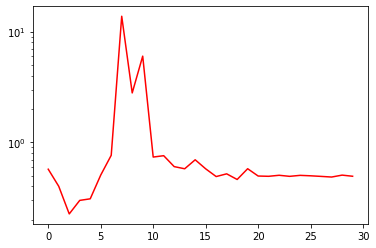

		ACCURACY


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel/pylab/backend_inline.py:179: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


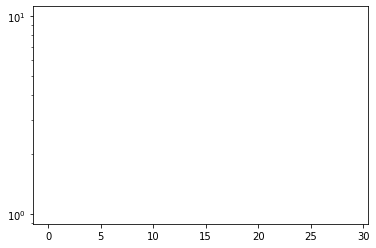

In [13]:
#DOM CLASS dest LOSS
print("\t\tLOSS")
plt.figure()
plt.plot(range(NUM_EPOCHS), losses_dest, color='red')
plt.semilogy()
plt.show()
print("\t\tACCURACY")
plt.figure()
plt.plot(range(NUM_EPOCHS), accuracy_dest, color='blue')
plt.semilogy()
plt.show()

**Test**

In [17]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(a_set))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 8/8 [00:06<00:00,  1.17it/s]

Test Accuracy: 0.19482421875
